In [1]:
#instal libraries

#pip install sentence-transformers
#pip install umap-learn
#pip install hdbscan

In [2]:
#import libraries

import re
from sentence_transformers import SentenceTransformer
import umap
import hdbscan
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

In [3]:
#reads in california constitution

with open('/Users/marijkevandergeer/Desktop/CAConstitution.txt', 'r') as f:
    data = f.read()

In [4]:
#data cleaning

def clean(text):
    pattern = r"\b(?=[MDCLXVIΙ])M{0,4}(CM|CD|D?C{0,3})(XC|XL|L?X{0,3})([IΙ]X|[IΙ]V|V?[IΙ]{0,3})\b\.?"
    return re.sub(pattern, ' ', text)

data = clean(data)
data = data.replace('SEC.', ' ')

In [5]:
#Removes all numbers
data = ''.join([i for i in data if not i.isdigit()])

In [6]:
data = data.split("\n")    

In [7]:
data

['PREAMBLE ',
 'We, the People of the State of  California, grateful to Almighty God for ',
 'our freedom, in order to secure and perpetuate its blessings, do establish ',
 'this  Constitution. ',
 'ARTICLE   ',
 ' DECLARATION OF RIGHTS ',
 'SECTION . [Repealed November , . See Section , below.] ',
 '[ Inalienable Rights] ',
 'SECTION . All people are by nature free and independent and have inalienable ',
 'rights. Among these are enjoying and defending life and liberty, ',
 'acquiring, possessing, and protecting property, and pursuing and obtaining ',
 'safety, happiness, and privacy. [New section adopted November , .] ',
 '[ Liberty of Speech and of the Press—Newspersons’ Refusal to  Disclose  Information ',
 'Sources Not Adjudged in  Contempt] ',
 '  . (a) Every person may freely speak, write and publish his or ',
 'her sentiments on all subjects, being responsible for the abuse of this right. ',
 'A law may not restrain or abridge liberty of speech or press. ',
 '(b) A publisher, e

In [8]:
model = SentenceTransformer('distilbert-base-nli-mean-tokens')
embeddings = model.encode(data, show_progress_bar = True)

Batches:   0%|          | 0/348 [00:00<?, ?it/s]

In [9]:
umap_embeddings = umap.UMAP(n_neighbors=15, n_components=2, metric='cosine').fit_transform(embeddings)

In [10]:
cluster = hdbscan.HDBSCAN(min_cluster_size=15,
                          metric='euclidean', 
                          cluster_selection_method='eom').fit(umap_embeddings)

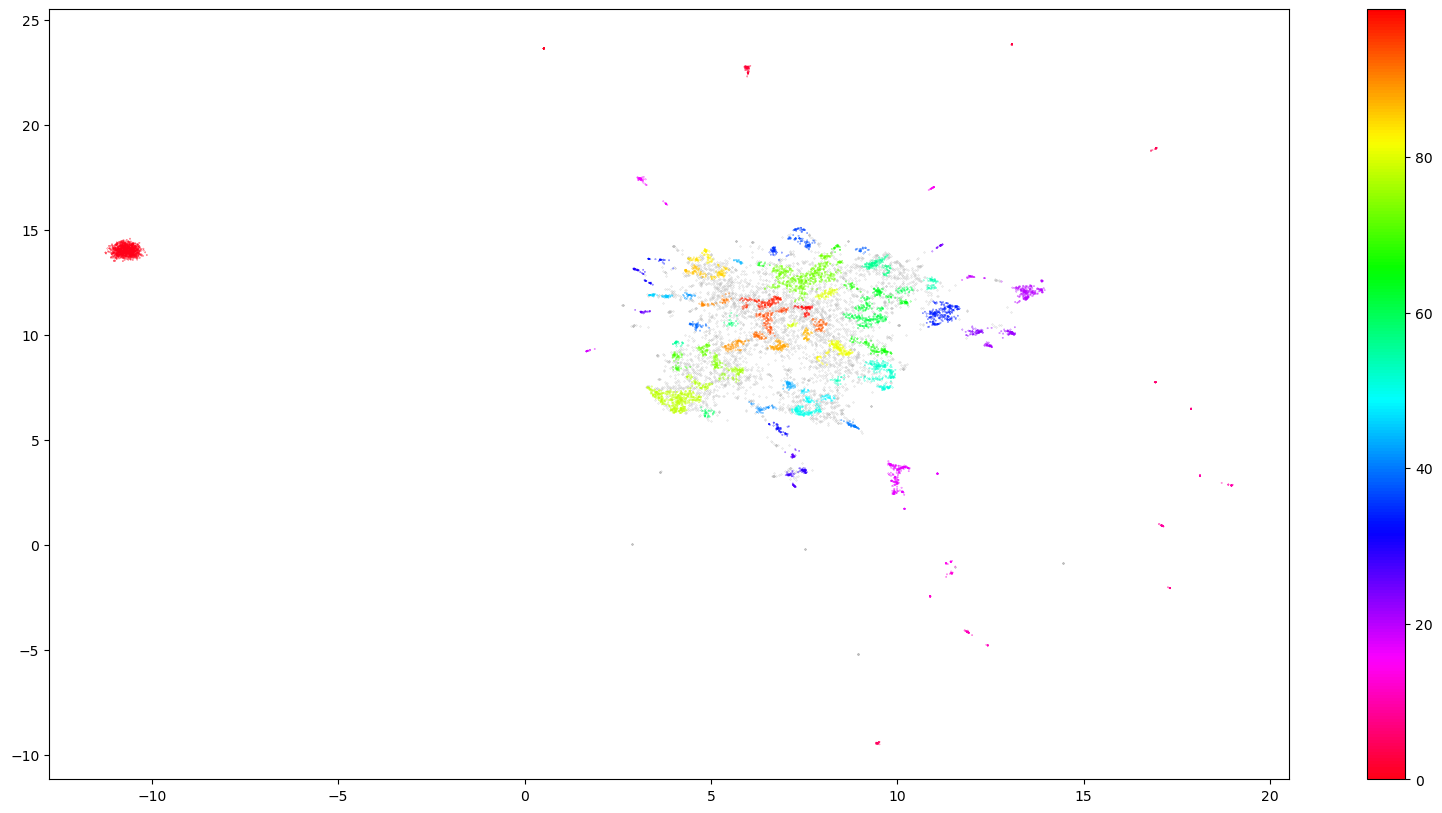

In [11]:
#umap_data = umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)
result = pd.DataFrame(umap_embeddings, columns=['x','y'])
result['labels'] = cluster.labels_

fig, ax = plt.subplots(figsize=(20,10))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]

plt.scatter(outliers.x, outliers.y, color = '#BDBDBD', s=0.05)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=0.05, cmap='hsv_r')
plt.colorbar()

In [12]:
docs_df = pd.DataFrame(data, columns=["Doc"])
docs_df['Topic'] = cluster.labels_
docs_df['Doc_ID'] = range(len(docs_df))
docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

In [13]:
def c_tf_idf(documents, m, ngram_range=(1, 1)):
    count = CountVectorizer(ngram_range=ngram_range, stop_words="english").fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count

In [14]:
tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m=len(data))

/var/folders/8z/5tmywm6s11d187fc5fg_fgb80000gn/T/ipykernel_5981/3267578824.py:5: RuntimeWarning: invalid value encountered in true_divide
  tf = np.divide(t.T, w)


In [15]:
def extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20):
    words = count.get_feature_names_out()
    labels = list(docs_per_topic.Topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    return top_n_words

def extract_topic_sizes(df):
    topic_sizes = (df.groupby(['Topic'])
                     .Doc
                     .count()
                     .reset_index()
                     .rename({"Topic": "Topic", "Doc": "Size"}, axis='columns')
                     .sort_values("Size", ascending=False))
    return topic_sizes

top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)
topic_sizes = extract_topic_sizes(docs_df); topic_sizes.head(10)

,Topic,Size
0,-1,3701
1,0,995
74,73,544
79,78,451
35,34,264
18,17,253
21,20,215
62,61,191
53,52,184
82,81,152


In [16]:
len(top_n_words)

101

In [22]:
index = [1, 74, 79, 35, 18]

In [23]:
for i in index:
    print("Topic #", i-1)
    print(top_n_words[i][:5])
    print()

Topic # 0
[('article', 3.238408583049263), ('zoning', 0.0), ('establishing', 0.0), ('establishmentiv', 0.0), ('estate', 0.0)]

Topic # 73
[('disqualification', 0.3489775588492388), ('overthrow', 0.2031581460559673), ('office', 0.15277682867673373), ('subversives', 0.15146903018885452), ('oath', 0.11527793283407371)]

Topic # 78
[('states', 0.6836848557143564), ('united', 0.6610084638666504), ('constitution', 0.5100209857768718), ('federal', 0.22407095348247988), ('law', 0.1024903439916893)]

Topic # 34
[('spouse', 0.49700380534820665), ('transfers', 0.2873613009588409), ('property', 0.22414554519067), ('veteran', 0.21865915688864), ('deceased', 0.20508609308918715)]

Topic # 17
[('reciprocity', 1.9824391163196016), ('privatevi', 1.164506353299787), ('applicabilityii', 1.164506353299787), ('censurevi', 1.164506353299787), ('gaming', 0.9912195581598008)]

